In [1]:
include(raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\2.1.MP-IS-MCQMC_Lorenz.jl");
include(raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\2.1.MP-IS-MCQMC_Lotka_Volterra.jl");
include(raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\2.1.1.jl");

  Activating project at `C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Data_Libraries`


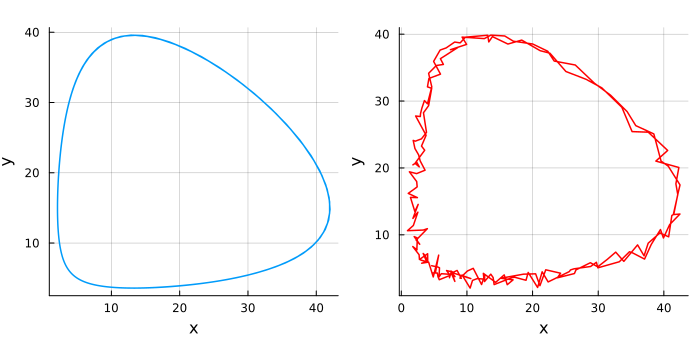

In [6]:
function lotka_volterra!(du, u, p, t)
    alpha, beta, delta, gamma = p
    x, y = u
    du[1] =  alpha*x - beta*x*y
    du[2] = -gamma*y + delta*x*y
end

Theta_true = (1.5, 0.1, 0.075, 1.0); tspan = (0.0, 10.0); dt = 0.05; u0 = [5.0, 5.0]; 
lok_volt = ODEProblem(lotka_volterra!, u0, tspan, Theta_true);
sol = solve(lok_volt, Tsit5(), saveat=dt);                            # Float64 Matrix

# Noisy Data 
sigma_eta = 0.5 * I(2)              
obs_noisy = Array(sol) .+ rand(MvNormal(zeros(2), sigma_eta), size(sol, 2)); 

gr()

p1 = plot(sol[1,:], sol[2,:], linewidth = 1.5, 
          xlabel = "x", ylabel = "y",
          legend = false, grid = true, gridalpha = 0.3 )

p2 = plot(obs_noisy[1,:], obs_noisy[2,:], linewidth = 1.5,
    xlabel = "x", ylabel = "y",
    legend = false, color = "red", grid = true, gridalpha = 0.3)

plot( p1, p2, layout = (1, 2), size = (700, 350), bottom_margin=5mm, top_margin=5mm)

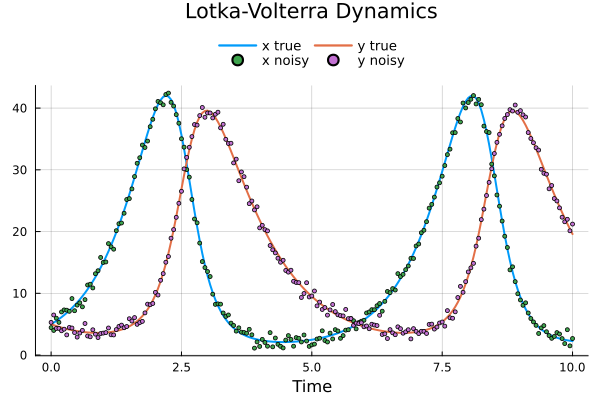

In [23]:
plot(sol.t, sol[1,:], lw=2, label="x true", grid=:true, gridalpha=0.3, legendfontsize=9, 
      legend=:outertop, legendcolumns=2, legendborder=false,legend_foreground_color=:transparent,
      title = "Lotka-Volterra Dynamics", fontsize =10) 
plot!(sol.t, sol[2,:], lw=2, label="y true")
scatter!(sol.t, obs_noisy[1,:], ms=2.2, label="x noisy")
scatter!(sol.t, obs_noisy[2,:], ms=2.2, label="y noisy")
xlabel!("Time") 

In [70]:
priors = (Normal(log(1.0),1.0),   # alpha
          Normal(log(1.0),1.0),   # beta
          Normal(log(1.0),1.0),   # delta
          Normal(log(1.0),1.0))   # gamma

logprior_par = p -> (logpdf(priors[1], p[1]) +
                     logpdf(priors[2], p[2]) +
                     logpdf(priors[3], p[3]) +
                     logpdf(priors[4], p[4]))


init_par = log.([2, 2, 2, 2])

N_prop = 8; N_iter = 20
seq = rand(N_iter*(N_prop+1), 5)

out = MP_IS_MALA_LV(lotka_volterra!, u0, obs_noisy, sigma_eta, tspan, dt, logprior_par,
                    init_par; seq=seq, N_prop=N_prop, N_iter=N_iter,
                    step_size=0.001, h_der=1e-4);


In [71]:
out.proposals[:,:,1]

9×4 Matrix{Float64}:
 0.693147  0.693147  0.693147  0.693147
 0.691353  0.694579  0.693544  0.692246
 0.689111  0.692437  0.693694  0.689249
 0.692284  0.693204  0.693329  0.68995
 0.691006  0.694461  0.693333  0.689718
 0.689818  0.692756  0.693485  0.689366
 0.689588  0.694809  0.6935    0.691229
 0.689989  0.694303  0.693339  0.690418
 0.690998  0.695221  0.69101   0.691365

In [72]:
out.proposals[:,:,20]

9×4 Matrix{Float64}:
 0.680575  0.697487  0.698917  0.674645
 0.672707  0.700409  0.701594  0.666827
 0.673814  0.698473  0.702477  0.667113
 0.675348  0.699081  0.702516  0.666483
 0.673822  0.697833  0.702432  0.666441
 0.674642  0.698422  0.702634  0.667456
 0.674805  0.700189  0.70276   0.666659
 0.674933  0.699629  0.703287  0.666867
 0.673638  0.698315  0.701304  0.668434

In [73]:
out.weights_last

20×9 Matrix{Float64}:
 0.220084  0.138091    0.063355    …  0.085738    0.0830107   0.128269
 0.600336  0.025483    0.0449434      0.0518166   0.057355    0.0352586
 0.521965  0.0738861   0.0382138      0.0332177   0.0760416   0.124055
 0.708883  0.0505828   0.0234372      0.0544362   0.0227587   0.0561274
 0.723248  0.049915    0.0722954      0.00440732  0.0359189   0.0416207
 0.836917  0.0159682   0.0437305   …  0.0110894   0.0179965   0.0177016
 0.821635  0.0305104   0.025254       0.00030231  0.0322639   0.0180844
 0.91753   9.70295e-5  0.00941791     0.0112756   0.0118641   0.00673934
 0.915462  0.0080677   0.0171438      0.00643249  0.0194196   0.0107667
 0.852683  0.0233241   0.0100014      0.0182663   0.0115277   0.0224589
 0.798045  0.0317778   0.0761805   …  0.0144197   2.48763e-5  0.019316
 0.903721  0.00845837  0.00826915     0.011301    0.018195    0.0108344
 0.805547  0.0193797   0.0469772      0.0302224   0.0141079   0.0197375
 0.835533  0.0314333   4.2395e-5      0.0201

In [54]:
out.grad

4-element Vector{Float64}:
 -2512.8385677817278
   512.4396760948002
   776.9039293634704
 -3623.5340143321077

In [8]:
obs_noisy

2×201 Matrix{Float64}:
 4.6278   5.55573  5.81984  5.75334  6.09223  …   2.7374   2.3572   1.76897
 5.37627  5.18629  5.06264  3.71006  4.18467     20.1581  20.8368  20.4622

In [7]:
priors = (
    LogNormal(log(1.0), 1.0),   # alpha
    LogNormal(log(0.1), 1.0),   # beta
    LogNormal(log(0.1), 1.0),   # delta
    LogNormal(log(1.0), 1.0)    # gamma
)

logprior_par = p -> (
    logpdf(priors[1], p[1]) +
    logpdf(priors[2], p[2]) +
    logpdf(priors[3], p[3]) +
    logpdf(priors[4], p[4])
)

u0 = [10.0, 5.0]; tspan = (0.0, 10.0); dt = 0.1
init_par = log.([1.0, 0.1, 0.1, 1.0])

N_iter = 20; N_prop = 8; seq = rand(N_iter*(N_prop+1), 5)   # in practice you’d use wcud sequence

# Call the sampler
out = MP_IS_sMALA_LV(
    lotka_volterra!, u0, obs_noisy, sigma_eta, tspan, dt, logprior_par,
    init_par; seq=seq, N_prop=N_prop, N_iter=N_iter,
    step_size=0.05, h_der=1e-4
)

println("Acceptance proxy: ", out.accept_proxy)
println("First 5 samples: ")
println(out.chain[1:5,:])

AssertionError: AssertionError: size(obs) == size(sim)

### **Lorenz System**

In [2]:
sigma = 10.0
rho = 28.0
beta = 8/3

# Lorenz system
function lorenz!(du, u, p, t)
    x, y, z = u
    du[1] = sigma * (y - x)
    du[2] = x * (rho - z) - y
    du[3] = x*y - beta*z
end

tspan = (0.0, 1.0)
u0 = [1.0, 1.0, 1.0];

prob = ODEProblem(lorenz!, u0, tspan);
step = 0.1; sol = solve(prob, Tsit5(), saveat=step);                   # Float64 Matrix
sigma_eta = 0.1 * I(3)              
dist = MvNormal(zeros(3), sigma_eta)   
                                  
obs_noisy = Array(sol) .+ rand(dist, size(sol, 2)); 

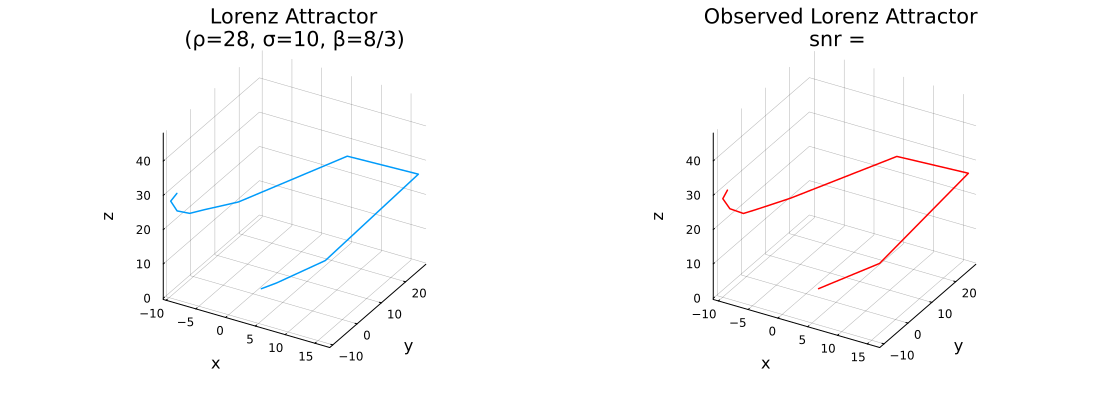

In [3]:
gr()

p1 = plot(sol[1,:], sol[2,:], sol[3,:], linewidth = 1.5, 
           title = "Lorenz Attractor\n" * "(ρ=28, σ=10, β=8/3)", 
           xlabel = "x", ylabel = "y", zlabel = "z", 
           legend = false, grid = true, gridalpha = 0.3 )

p2 = plot(obs_noisy[1,:], obs_noisy[2,:], obs_noisy[3,:], linewidth = 1.5,
    title = "Observed Lorenz Attractor \n" * "snr =  ",
    xlabel = "x", ylabel = "y", zlabel = "z",
    legend = false, color = "red", grid = true, gridalpha = 0.3)

plot( p1, p2, layout = (1, 2), size = (1100, 400))

In [4]:
# Known Σ 
Σ = Matrix(sigma_eta)         

# Prior
μ0 = obs_noisy[:, 1]
prior_std_x0 = 0.1
prior_x0 = MvNormal(μ0, Diagonal(fill(prior_std_x0^2, 3)))

# Log-density of the prior 
logprior_x0 = x0 -> logpdf(prior_x0, x0)                    # Lambda function

# Sample initial state from the prior
rng = MersenneTwister(1234); x0_init = rand(rng, prior_x0)

3-element Vector{Float64}:
 1.489799356521385
 1.5613259838869409
 1.102359432567175

In [6]:
# QMC/CUD uniforms: ((N+1)L)×4
N_prop = 3; N_iter = 30
wcud = rand(N_iter*(N_prop+1), 4)  # replace with your CUD/QMC block

out = MP_IS_MALA(
                    lorenz!, 
                    x0_init;
                    obs = obs_noisy,
                    cov_mat   = Σ,
                    tspan = tspan,
                    dt    = step,          
                    seq = wcud,
                    N_prop = N_prop,
                    N_iter = N_iter,
                    step_size = 0.005,
                    logprior_x0 = logprior_x0,
                    h_der = 1e-6)

chains = out.chain_x0

UndefVarError: UndefVarError: `acc_proxy` not defined in local scope
Suggestion: check for an assignment to a local variable that shadows a global of the same name.

In [ ]:
out.grad

In [ ]:
out.proposals

In [ ]:
out.weighted_mean

In [ ]:
# --- raccogli le 4 catene ---
A = [results[i].chain_theta[burn_in:end, :] for i in 1:4]   # ciascuna (N, d)
N, d = size(A[1])
@assert all(size(A[i]) == (N, d) for i in 1:4)

# --- array 3D nella forma (iter, param, chain) attesa da MCMCChains ---
arr = Array{Float64}(undef, N, d, 4)
for c in 1:4
    arr[:, :, c] = A[c]
end

pnames = Symbol.("θ", 1:d)
chn = Chains(arr, pnames)  

describe(chn)